In [1]:
import os
import random

from PIL import Image

from HOG import *
from SVM import *

import matplotlib.pyplot as plt


def resize_img(infile, outfile):
    im = Image.open(infile)
    (x, y) = im.size  # read image size
    x_s = 64  # define standard width
    y_s = y * x_s // x  # calc height based on standard width
    out = im.resize((x_s, y_s), Image.ANTIALIAS)  # resize image with high-quality
    out.save(outfile)


def plot_vector(dataSet, label, b, alphlas):
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(len(dataSet)):
        if alphlas[i] == 0.0:
            xcord1.append(dataSet[i][0])
            ycord1.append(dataSet[i][1])
        else:
            xcord2.append(dataSet[i][0])  # 支持向量
            ycord2.append(dataSet[i][1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='black', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='red')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


#  读取训练集,args样本个数
def loadDataSet(pos_path,pos_count,neg_path,neg_count):
    dataSet = []
    label = []
    posImgs = os.listdir(pos_path)  # 正样本
    negImgs = os.listdir(neg_path)

    for i in range(min(len(posImgs),pos_count)):  # 读取正样本
        path = pos_path+ '/' + posImgs[i]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图
        hog_vec, hog_img = Hog_descriptor(img).extract()  # 计算HOG特征描述子
        dataSet.append(hog_vec)
        label.append(1)

    for i in range(min(len(negImgs),neg_count)):  # 读取负样本
        path = neg_path+ '/' + negImgs[i]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图
        hog_vec, hog_img = Hog_descriptor(img).extract()  # 计算HOG特征描述子
        dataSet.append(hog_vec)
        label.append(-1)
    return dataSet, label


def plot_compare_2img(ori_img, hog_img):
    '''
        绘制两幅图，做对比
    '''
    plt.figure(figsize=(6.4, 2.0 * 3.2))
    plt.subplot(1, 2, 1)
    plt.imshow(ori_img, cmap=plt.cm.gray)
    plt.subplot(1, 2, 2)
    plt.imshow(hog_img, cmap=plt.cm.gray)  # 输出灰度图
    plt.show()


def do_training(pos_path,pos_c,neg_path,neg_c):  # 训练产生w b alpha
    dataSet, label = loadDataSet(pos_path,pos_c,neg_path,neg_c)  # HOG特征向量的训练集
    ws, b, alpha = SMO(dataSetIn=dataSet, classLabels=label, C=0.6, toler=0.001, maxIter=60)  # SVM训练
    #  ws(1,n),b(1,1),alpha(m,1)    np.matrix
    fw = open('weights.txt', 'w')
    for i in range(ws.shape[1]):
        fw.write(str(ws[0, i]) + ' ')
    fw.write('\n' + str(b[0,0]) + '\n')
    for i in range(alpha.shape[0]):
        fw.write(str(alpha[i, 0]) + ' ')
    fw.write('\n')


# 给图片加框 https://www.jb51.net/article/155363.htm
def test(test_path,slide_len,width_step,ht):

    #  ws(1,n),b(1,1),alpha(m,1)    请保证ws,alpha为np.matrix
    ws = []
    fr = open('weights.txt')
    for i in fr.readline().strip().split(' '):
        ws.append(float(i))
    b=float(fr.readline().strip())
    fr.close()
    ws = np.mat(ws)

    #  下面进行分类

    test_img = cv2.imread(test_path)  # 原始彩色图
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)    # 颜色问题，转换一下
    test_img_gray = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)  # 灰度图

    height, width = test_img_gray.shape  # 高和宽
    # slide_len=4    # 滑动步长
    # width_step=100   # 窗口宽度步长
    win_sum=0; person = 0
    for i in range(0,height,slide_len):
        for j in range(0,width,slide_len):
            for wid in range(width_step,width,width_step):
                hei = wid*ht
                if i+hei>=height or j+wid>=width: break
                win_sum+=1
                window = test_img_gray[i:i + hei, j:j + wid]  # 剪出窗口
                window = cv2.resize(window, (64, 128))  # 调整窗口像素为128*64

                hog_vec, hog_img = Hog_descriptor(window).extract()    # HOG
                fx = np.mat(hog_vec) * ws.T + b  # 预测
                if fx > 0:
                    person += 1
                    cv2.rectangle(test_img, (j, i), (j + wid, i + hei), (255, 0, random.randint(0,255)), 3)
                    # plot_compare_2img(window,hog_img)
    print('滑动步长%d,窗宽步长%d,检测窗口个数%d,检测到%d次目标' % (slide_len,width_step,win_sum,person))
    plt.imshow(test_img)
    plt.show()

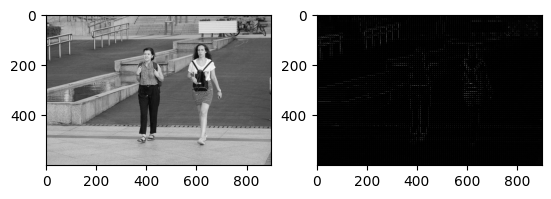

In [23]:
ori_img = cv2.imread('F:\\2023\\hog_svm-master\\images\\test\\girl.jpg', cv2.IMREAD_GRAYSCALE)  # 灰度图
hog_vec, hog_img = Hog_descriptor(ori_img).extract()

plt.figure(figsize=(6.4, 2.0 * 3.2))
plt.subplot(1, 2, 1)
plt.imshow(ori_img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap=plt.cm.gray)  # 输出灰度图
plt.show()

L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 4
L==H
fullSet, iter: 0 i:5, pairs changed 4
L==H
fullSet, iter: 0 i:6, pairs changed 4
L==H
fullSet, iter: 0 i:7, pairs changed 4
L==H
fullSet, iter: 0 i:8, pairs changed 4
L==H
fullSet, iter: 0 i:9, pairs changed 4
L==H
fullSet, iter: 0 i:10, pairs changed 4
L==H
fullSet, iter: 0 i:11, pairs changed 4
L==H
fullSet, iter: 0 i:12, pairs changed 4
L==H
fullSet, iter: 0 i:13, pairs changed 4
L==H
fullSet, iter: 0 i:14, pairs changed 4
L==H
fullSet, iter: 0 i:15, pairs changed 4
L==H
fullSet, iter: 0 i:16, pairs changed 4
L==H
fullSet, iter: 0 i:17, pairs changed 4
L==H
fullSet, iter: 0 i:18, pairs changed 4
L==H
fullSet, iter: 0 i:19, pairs changed 4
L==H
fullSet, iter: 0 i:20, pairs changed 4
L==H
fullSet, iter: 0 i:21, pairs changed 4
L==H
fullSet, iter: 0 i:22, pairs changed 4
L==H
fullSet, iter

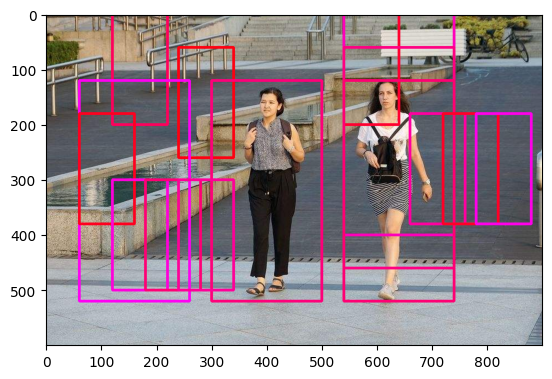

In [2]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput
graphviz = GraphvizOutput()
graphviz.output_file = 'svm+hog.png'
with PyCallGraph(output=graphviz):
    do_training('F:\\2023\\hog_svm-master\\images\\train\\pos',200,'F:\\2023\\hog_svm-master\\images\\train\\neg',200)
    test('F:\\2023\\hog_svm-master\\images\\test\\girl.jpg',60,100,2)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 4
fullSet, iter: 0 i:5, pairs changed 5
fullSet, iter: 0 i:6, pairs changed 6
fullSet, iter: 0 i:7, pairs changed 7
fullSet, iter: 0 i:8, pairs changed 8
fullSet, iter: 0 i:9, pairs changed 9
fullSet, iter: 0 i:10, pairs changed 9
fullSet, iter: 0 i:11, pairs changed 9
fullSet, iter: 0 i:12, pairs changed 9
fullSet, iter: 0 i:13, pairs changed 10
fullSet, iter: 0 i:14, pairs changed 10
fullSet, iter: 0 i:15, pairs changed 10
fullSet, iter: 0 i:16, pairs changed 10
fullSet, iter: 0 i:17, pairs changed 10
fullSet, iter: 0 i:18, pairs changed 10
fullSet, iter: 0 i:19, pairs changed 10
fullSet, iter: 0 i:20, pairs changed 10
fullSet, iter: 0 i:21, pairs changed 10
fullSet, iter: 0 i:22, pairs changed 10
fullSet, iter: 0 i:23, pairs changed 10
fullSet, iter: 0 i:24, pairs changed 10
fullSet, iter: 0 i:25, 

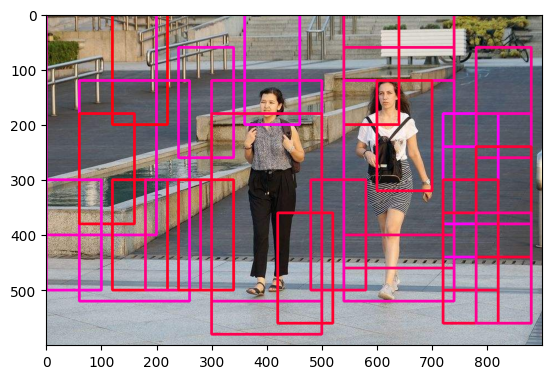

In [2]:
do_training('F:\\2023\\hog_svm-master\\images\\train\\pos',200,'F:\\2023\\hog_svm-master\\images\\train\\neg',200)
test('F:\\2023\\hog_svm-master\\images\\test\\girl.jpg',60,100,2)

In [3]:
def resize_images(directory, size):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # 或者其他你需要的图片格式
            img = Image.open(os.path.join(directory, filename))
            img_resized = img.resize(size)
            img_resized.save(os.path.join(directory, filename))

# 调用函数
resize_images('F:\\2023\\objectDetection\\data\\plane\\test', (64, 128))

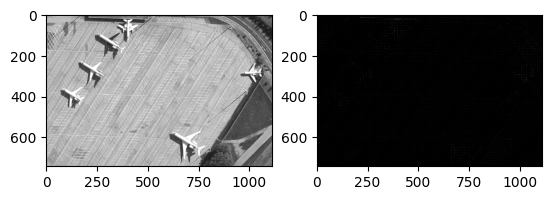

In [6]:
ori_img = cv2.imread('F:\\2023\\objectDetection\\plane_many.jpg', cv2.IMREAD_GRAYSCALE)  # 灰度图
hog_vec, hog_img = Hog_descriptor(ori_img).extract()

plt.figure(figsize=(6.4, 2.0 * 3.2))
plt.subplot(1, 2, 1)
plt.imshow(ori_img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap=plt.cm.gray)  # 输出灰度图
plt.show()

L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 4
fullSet, iter: 0 i:5, pairs changed 5
fullSet, iter: 0 i:6, pairs changed 5
fullSet, iter: 0 i:7, pairs changed 6
fullSet, iter: 0 i:8, pairs changed 7
fullSet, iter: 0 i:9, pairs changed 8
L==H
fullSet, iter: 0 i:10, pairs changed 8
fullSet, iter: 0 i:11, pairs changed 8
L==H
fullSet, iter: 0 i:12, pairs changed 8
L==H
fullSet, iter: 0 i:13, pairs changed 8
L==H
fullSet, iter: 0 i:14, pairs changed 8
L==H
fullSet, iter: 0 i:15, pairs changed 8
fullSet, iter: 0 i:16, pairs changed 8
L==H
fullSet, iter: 0 i:17, pairs changed 8
L==H
fullSet, iter: 0 i:18, pairs changed 8
fullSet, iter: 0 i:19, pairs changed 8
L==H
fullSet, iter: 0 i:20, pairs changed 8
L==H
fullSet, iter: 0 i:21, pairs changed 8
L==H
fullSet, iter: 0 i:22, pairs changed 8
fullSet, iter: 0 i:23, pairs changed 8
L==H
fullSet, iter:

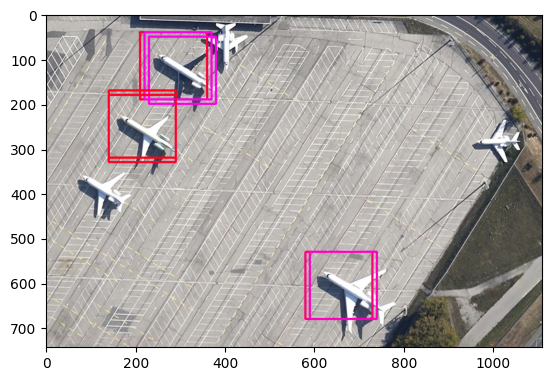

In [3]:
do_training('F:\\2023\\objectDetection\\data\\plane\\test',200,'F:\\2023\\hog_svm-master\\images\\train\\neg',200)
test('F:\\2023\\objectDetection\\plane_many.jpg',10,150,1)